In [1]:
import os
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Input

In [2]:
dataset_path = "/content/drive/MyDrive/CVPR/data.pkl"
print(dataset_path)

/content/drive/MyDrive/CVPR/data.pkl


In [3]:
from google.colab import drive
drive.mount('/content/drive')
import pickle
with open(dataset_path, 'rb') as file:
    data = pickle.load(file)

Mounted at /content/drive


In [4]:
(train_imgs, train_labels), (test_imgs, test_labels) = data

train_imgs = train_imgs.astype('float32') / 255.0
test_imgs = test_imgs.astype('float32') / 255.0

print(f"Training images shape: {train_imgs.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test images shape: {test_imgs.shape}")
print(f"Test labels shape: {test_labels.shape}")

Training images shape: (4274, 256, 256, 3)
Training labels shape: (4274,)
Test images shape: (1069, 256, 256, 3)
Test labels shape: (1069,)


In [5]:
class_names =['AZIZ', 'MAHEDI', 'OLIVE', 'ZAFRUL']
from sklearn.model_selection import train_test_split
train_imgs, train_labels = train_imgs[:1500], train_labels[:1500]
test_imgs, test_labels = test_imgs[:500], test_labels[:500]
train_imgs, val_imgs, train_labels, val_labels = train_test_split(train_imgs, train_labels, test_size=0.2, random_state=42)

print(f"Training images shape: {train_imgs.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Validation images shape: {val_imgs.shape}")
print(f"Validation labels shape: {val_labels.shape}")


Training images shape: (1200, 256, 256, 3)
Training labels shape: (1200,)
Validation images shape: (300, 256, 256, 3)
Validation labels shape: (300,)


In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [8]:
# Load the MobileNet model pre-trained on ImageNet without the top classification layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(train_imgs.shape[1], train_imgs.shape[2], 3))

# Freeze the base model layers
base_model.trainable = False

# Add new layers for your specific classification task
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling layer
x = Dense(1024, activation='relu')(x)  # Fully connected layer
predictions = Dense(len(class_names), activation='softmax')(x)  # Output layer for classification

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
datagen.fit(train_imgs)

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(
    datagen.flow(train_imgs, train_labels, batch_size=12),
    epochs=25,
    validation_data=(val_imgs, val_labels),
    callbacks=[early_stopping, reduce_lr],
)

# Unfreeze the base model for fine-tuning
base_model.trainable = True
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


<ipython-input-8-0d6668a7c308>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(train_imgs.shape[1], train_imgs.shape[2], 3))


Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 200ms/step - accuracy: 0.6793 - loss: 0.8248 - val_accuracy: 0.9833 - val_loss: 0.1120 - learning_rate: 1.0000e-04
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 168ms/step - accuracy: 0.9852 - loss: 0.1031 - val_accuracy: 0.9867 - val_loss: 0.0591 - learning_rate: 1.0000e-04
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - accuracy: 0.9897 - loss: 0.0569 - val_accuracy: 0.9867 - val_loss: 0.0381 - learning_rate: 1.0000e-04
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 167ms/step - accuracy: 0.9898 - loss: 0.0419 - val_accuracy: 0.9900 - val_loss: 0.0274 - learning_rate: 1.0000e-04
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 173ms/step - accuracy: 0.9937 - loss: 0.0272 - val_accuracy: 0.9933 - val_loss: 0.0218 - learning_rate: 1.0000e-04
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 164ms/step - accuracy: 0.9988 - loss: 0.0269 - val_accuracy: 0.9900 - val_loss: 0.0216 - learning_rate: 1.0000e-04
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 17

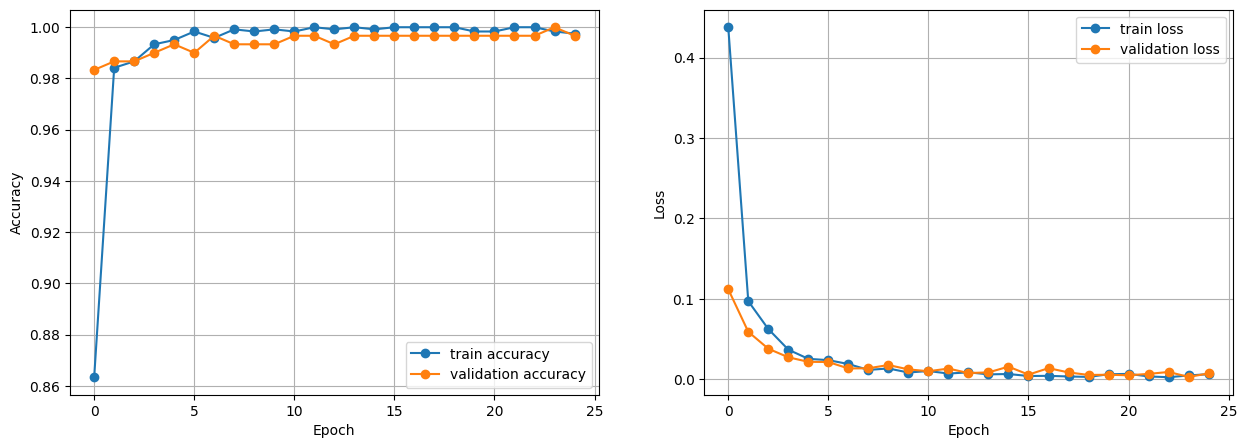

In [9]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], 'o-', label='train accuracy')
plt.plot(history.history['val_accuracy'], 'o-', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], 'o-', label='train loss')
plt.plot(history.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step


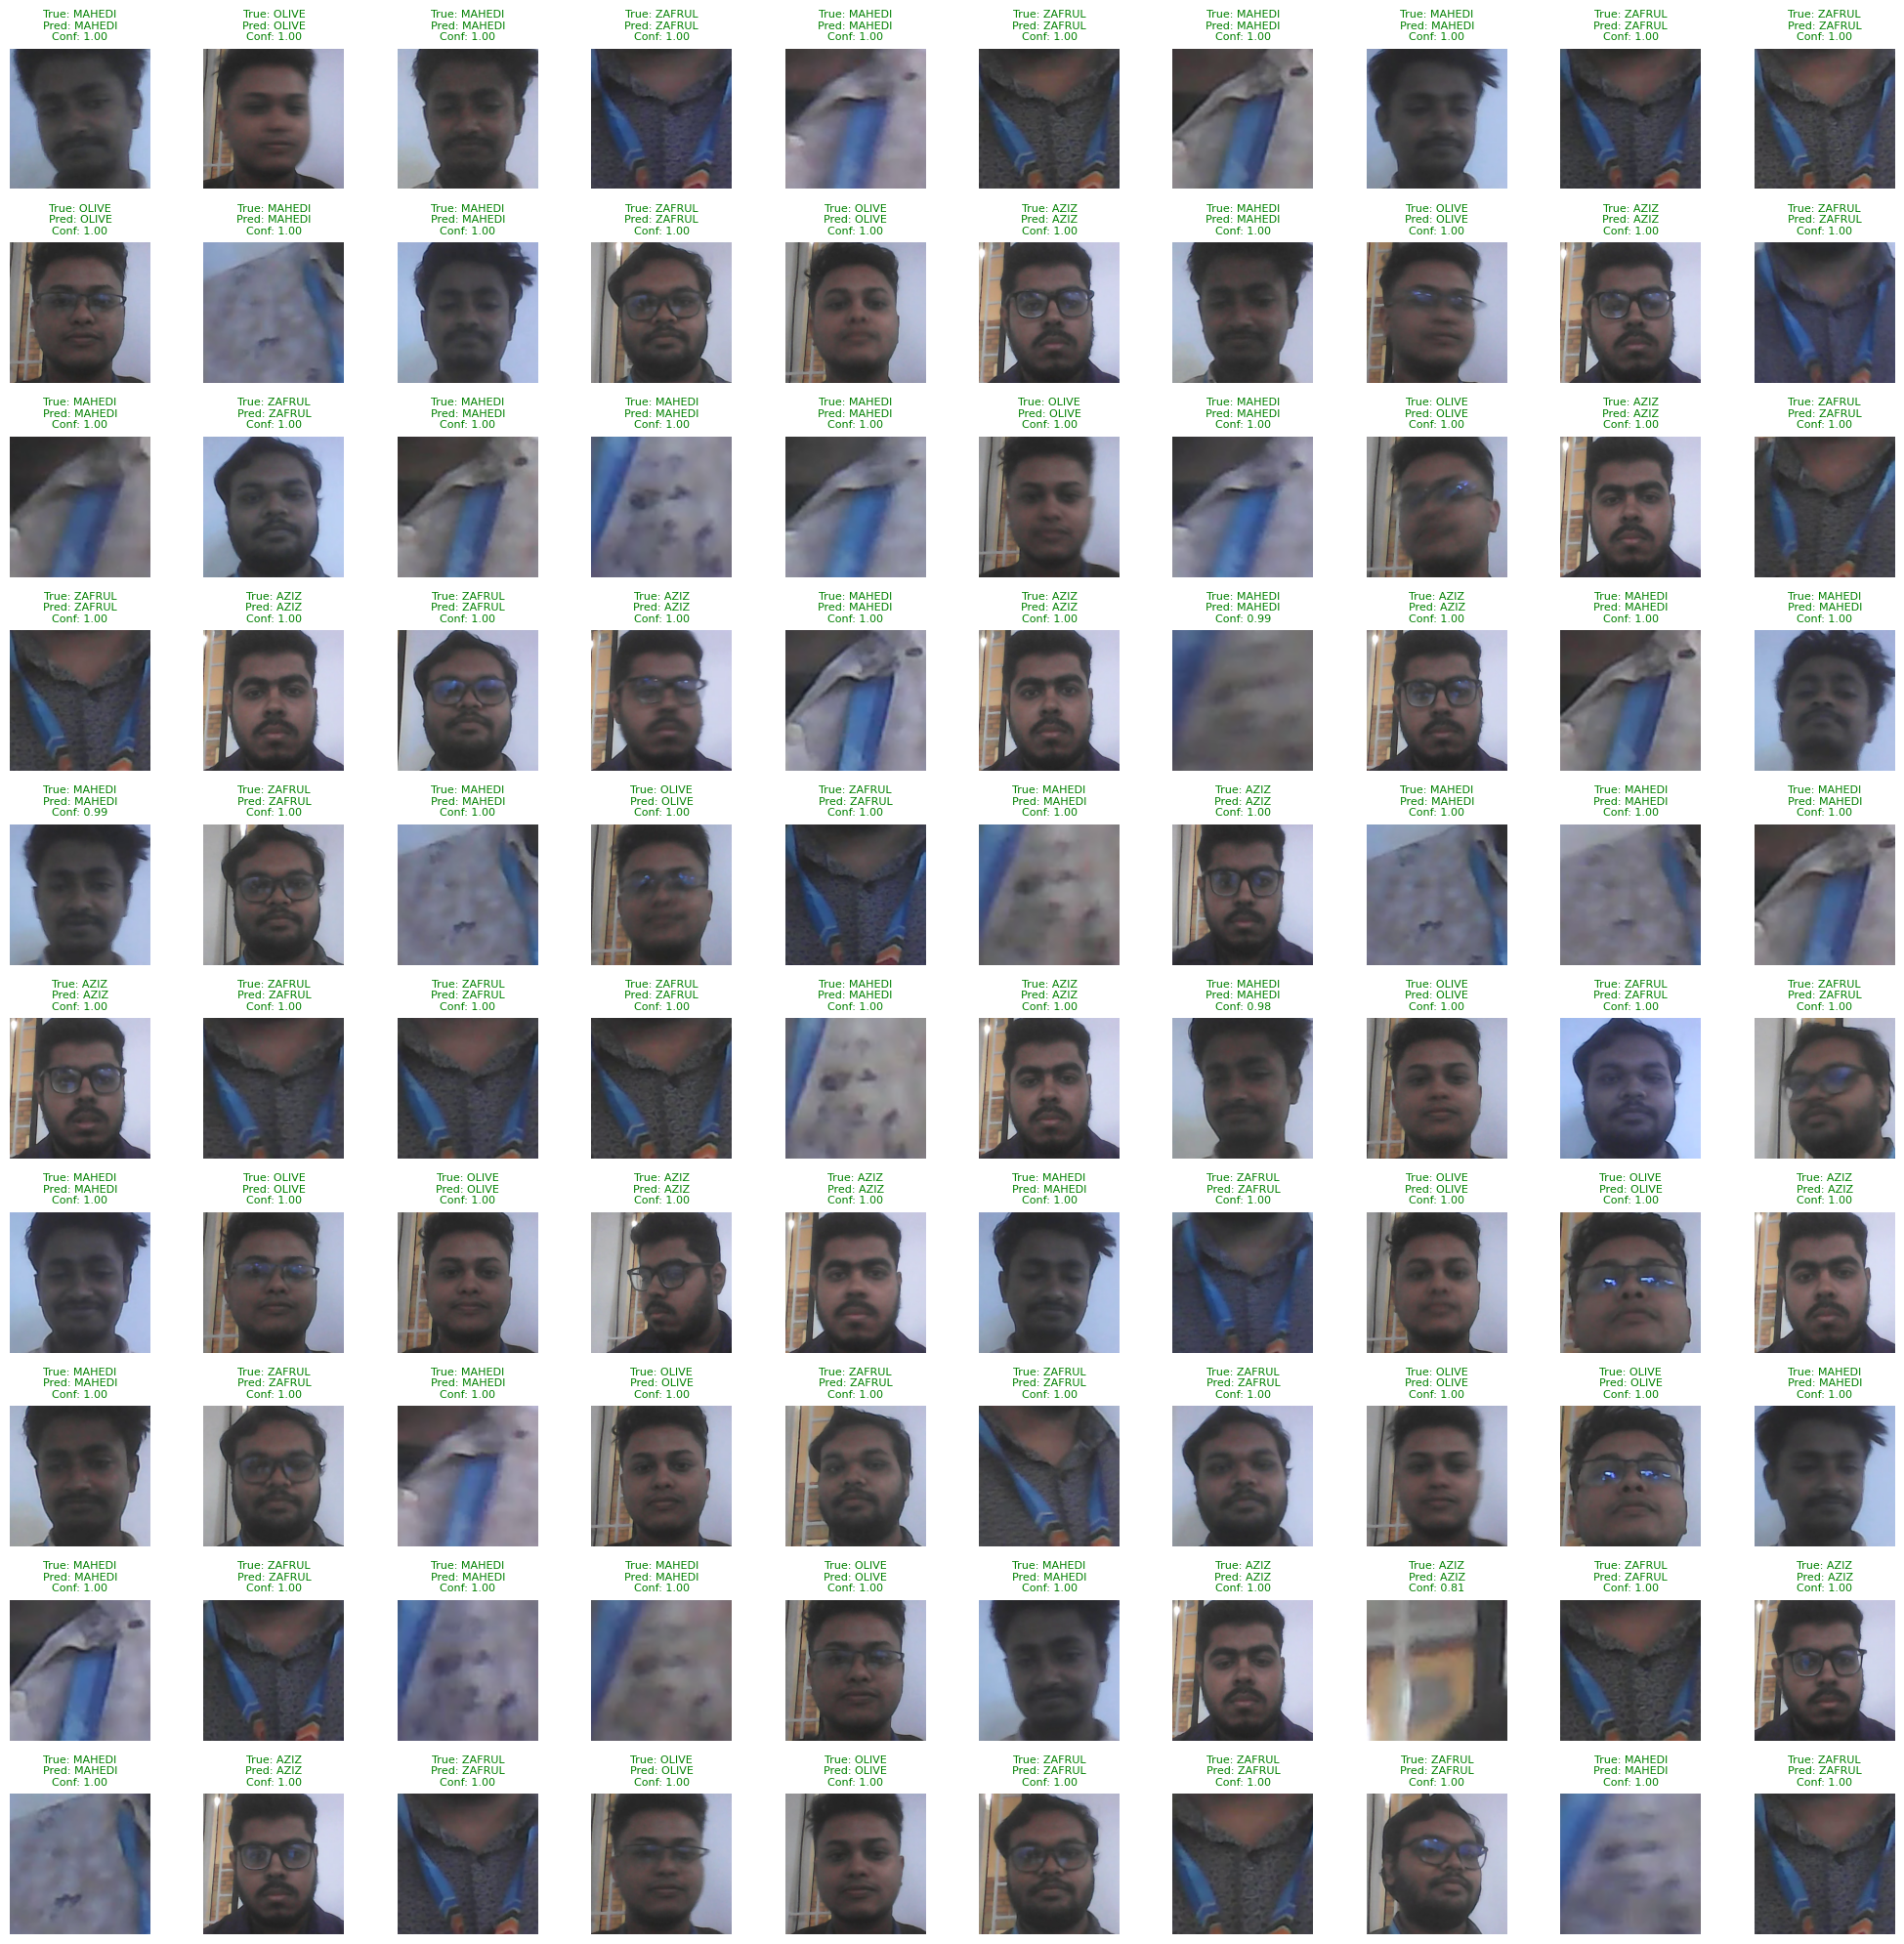

In [10]:
predictions = model.predict(val_imgs)
predicted_classes = np.argmax(predictions, axis=1)
confidence_levels = np.max(predictions, axis=1)

fig, axes = plt.subplots(10, 10, figsize=(20, 20))
axes = axes.ravel()

for i in range(100):
    axes[i].imshow(val_imgs[i])
    axes[i].axis('off')

    true_label = class_names[val_labels[i]]
    predicted_label = class_names[predicted_classes[i]]
    confidence = confidence_levels[i]

    color = "green" if predicted_classes[i] == val_labels[i] else "red"

    axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}\nConf: {confidence:.2f}", color=color, fontsize=8)

plt.tight_layout()
plt.show()

In [11]:
model.save('face_recognition_model.keras')

In [12]:
with open('class_labels.pkl', 'wb') as file:
    pickle.dump(class_names, file)